In [1]:
# This code now can work well, it is suitable for both MNIST and fashion-MNIST
from __future__ import print_function
import pandas as pd
import keras
# from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras import backend as k
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 

In [2]:
#load mnist dataset
# (X_train, y_train), (X_test, y_test) = mnist.load_data() 
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() 
#everytime loading data won't be so easy :)

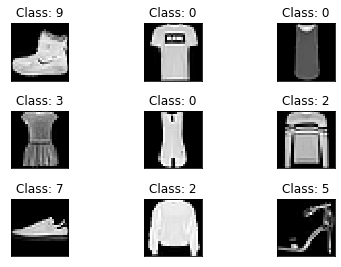

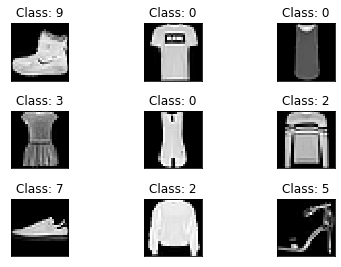

In [3]:
#visualising first 9 data from training dataset
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Class: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [4]:
# let's print the actual data shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


In [5]:
#input image size 28*28
img_rows , img_cols = 28, 28

In [6]:
#reshaping
#this assumes our data format
#For 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while 
#"channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).
if k.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
#more reshaping
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64))


In [8]:
#set number of categories
num_category = 10

In [9]:
# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_category)
y_test = keras.utils.np_utils.to_categorical(y_test, num_category)
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [10]:
##model building
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(3, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,
                kernel_constraint=max_norm(1.)))
#32 convolution filters used each of size 3x3
#again
# model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#Choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(100, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.2))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(num_category, activation='softmax'))
#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

In [11]:
def find_neighbour_C(C_in,lt_df):
    tmp_arr = lt_df['Conductance'].values
    tmp_arr = np.sort(np.append(tmp_arr,C_in))
    ave_C = (tmp_arr[np.where(np.sort(tmp_arr)==C_in)[0]-1]+tmp_arr[np.where(np.sort(tmp_arr)==C_in)[0]+1])/2
#     print('find_neighbour_C C_in',C_in)
#     print("ave_C:",ave_C,np.where(np.sort(tmp_arr)==C_in)[0])
    if C_in > ave_C:
        C_out = tmp_arr[np.where(np.sort(tmp_arr)==C_in)[0]+1]
    else: 
        C_out = tmp_arr[np.where(np.sort(tmp_arr)==C_in)[0]-1]
    
    return C_out[0]



def map_weights(w_pre,w_post,w_max,w_min,ltp_df,ltd_df):
    
    data_df = pd.concat([ltp_df,ltd_df],axis=0)
    
    #set Conductance range
    C_max = np.sort(data_df['Conductance'].values)[-2]
    C_min = np.sort(data_df['Conductance'].values)[1]
#   print('C_max',C_max,'C_min',C_min)

    # solve linear equations and get patameters in the map function
    k = (C_max-C_min)/(w_max-w_min)
    b = C_min - k * w_min
    C_in = k * w_post + b
#     print(C_in)
    C_in = np.trunc(C_in*1000)/1000
#     print('\nmap_weights_C_in',C_in)
    
    ltp = w_post > w_pre
#     print('w_pre:{},w_post:{},ltp:{}'.format(w_pre,w_post,ltp))
    
#     find_C_vect = np.vectorize(find_neighbour_C)
#     find_C_vect.excluded.add(1)
    
    if ltp:
        C_out = find_neighbour_C(C_in,ltp_df)
    else:
        C_out = find_neighbour_C(C_in,ltd_df)
    
    w_out = (C_out - b) / k
#     print('mapped_weight:{}, error_percent:{}%'.format(w_out,(w_out-w_post)/w_post*100))
    return C_out,w_out

map_weights_vect = np.vectorize(map_weights,excluded=['w_max','w_min','ltp_df','ltd_df'])

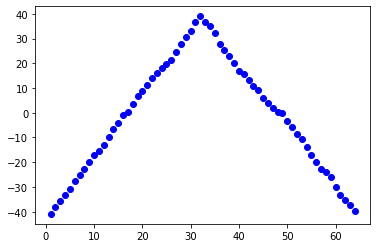

In [12]:
#import device data
data_path = './ltp-ltd.txt' #change file path
data_df = pd.read_csv(data_path , names=['spike_nums','Conductance'], sep='\t')
idx = data_df['Conductance'].idxmax()
ltp_df = data_df.iloc[:idx+1,:]
ltd_df = data_df.iloc[idx:,:]
plt.plot(data_df['spike_nums'].values,data_df['Conductance'].values,'ob')

In [13]:
batch_size = 128
num_epoch = 100

max_weight_list = []
min_weight_list = []

train_log = []
test_acc_log = []
test_loss_log = []

C_weights_log= []
C_bias_log = []

#model training
for i in range(num_epoch):

    print('\n\nepoch: {}/{}\n'.format(i + 1, num_epoch))
    
    #get weights before training
    for layer in filter(lambda x: 'conv2d' in x.name, model.layers):
        pre_weights = layer.get_weights()[0]
        pre_bias = layer.get_weights()[1]
#     print('pre_weights', pre_weights, '\npre_bias', pre_bias)
    
    #fit model
    model_log = model.fit(X_train,
                          y_train,
                          batch_size=batch_size,
                          epochs=1,
                          verbose=1,
                          validation_data=(X_test, y_test))
    train_log.append(model_log.history)
    
    test_score_original = model.evaluate(X_test, y_test, verbose=0)
    print(
        ' - Test_loss: {:4f} - Test_accuracy: {:4f}'
        .format(test_score_original[0], test_score_original[1]))
    
    #get weights after training
    for layer in filter(lambda x: 'conv2d' in x.name, model.layers):
        post_weights = layer.get_weights()[0]
        post_bias = layer.get_weights()[1]
#     print('post_weights', post_weights, '\npost_bias', post_bias)

    max_weight_list.append([np.max(post_weights), np.max(post_bias)])
    min_weight_list.append([np.min(post_weights), np.min(post_bias)])
    
    #mapping weights
    C_weights, mapped_weights = map_weights_vect(w_pre=pre_weights,
                                      w_post=post_weights,
                                      w_max=1,
                                      w_min=-1,
                                      ltp_df=ltp_df,
                                      ltd_df=ltd_df)
    C_bias, mapped_bias = map_weights_vect(w_pre=pre_bias,
                                   w_post=post_bias,
                                   w_max=0.6,
                                   w_min=-0.1,
                                   ltp_df=ltp_df,
                                   ltd_df=ltd_df)
    C_weights_log.append(C_weights)
    C_bias_log.append(C_bias)
    
    #set weights
    for layer in filter(lambda x: 'conv2d' in x.name, model.layers):
        layer.set_weights([mapped_weights, mapped_bias])

    for layer in filter(lambda x: 'conv2d' in x.name, model.layers):
        mapped_weights = layer.get_weights()[0]
        mapped_bias = layer.get_weights()[1]
        print('- mapping weights...')
#     print('mapped_weights: \n', mapped_weights, '\nmapped_bias:\n', mapped_bias)

#     train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score_map = model.evaluate(X_test, y_test, verbose=0)
    test_loss_log.append(test_score_map[0])
    test_acc_log.append(test_score_map[1])
    
    print(
        ' - Test_loss: {:4f} - Test_accuracy: {:4f}'
        .format(test_score_map[0], test_score_map[1]))
    
    if test_score_map[1]-test_score_original[1]<-0.05:
        break
        



epoch: 1/100

469/469 [==============================] - 4s 8ms/step - loss: 0.6745 - accuracy: 0.7625 - val_loss: 0.4654 - val_accuracy: 0.8316
 - Test_loss: 0.465433 - Test_accuracy: 0.831600
- mapping weights...
 - Test_loss: 0.471040 - Test_accuracy: 0.828200


epoch: 2/100

469/469 [==============================] - 4s 8ms/step - loss: 0.4887 - accuracy: 0.8223 - val_loss: 0.4272 - val_accuracy: 0.8450
 - Test_loss: 0.427239 - Test_accuracy: 0.845000
- mapping weights...
 - Test_loss: 0.425884 - Test_accuracy: 0.845500


epoch: 3/100

469/469 [==============================] - 4s 9ms/step - loss: 0.4455 - accuracy: 0.8372 - val_loss: 0.3935 - val_accuracy: 0.8576
 - Test_loss: 0.393513 - Test_accuracy: 0.857600
- mapping weights...
 - Test_loss: 0.399706 - Test_accuracy: 0.856200


epoch: 4/100

469/469 [==============================] - 4s 8ms/step - loss: 0.4205 - accuracy: 0.8478 - val_loss: 0.3793 - val_accuracy: 0.8609
 - Test_loss: 0.379251 - Test_accuracy: 0.860900
- mapp

In [14]:
# post_weights

In [15]:
# mapped_weights

In [16]:
# (mapped_weights - post_weights)/post_weights

In [17]:
# max_weight_list 

In [18]:
# min_weight_list

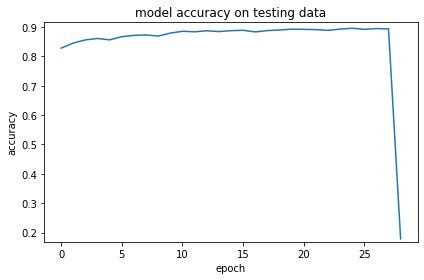

In [19]:
# plotting the metrics
fig = plt.figure()
# plt.subplot(2,1,1)
# plt.plot(model_log.history['val_accuracy'])
plt.plot(test_acc_log)
plt.title('model accuracy on testing data')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(np.min(test_acc_log)-0.01,np.max(test_acc_log)+0.02)

# plt.subplot(2,1,2)
# plt.plot(test_loss_log)
# plt.title('model loss on testing data')
# plt.ylabel('loss')
# plt.xlabel('epoch')


plt.tight_layout()
plt.savefig('./cnn_with_device_fashion_mnist.png',dpi=600)
plt.savefig('./cnn_with_device_fashion_mnist.svg')
plt.show()

In [20]:
#Save the model
# serialize model to JSON
model_digit_json = model.to_json()
with open("model_digit.json", "w") as json_file:
    json_file.write(model_digit_json)
# serialize weights to HDF5
model.save_weights("model_digit.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
#save device weights and bias
save_C_weights = np.array(C_weights_log)
np.save('./Device_weights.npy',save_C_weights)
save_C_bias = np.array(C_bias_log)
np.save('./Device_bias.npy',save_C_bias)

[[ 10.7536  -33.1429  -33.1429 ]
 [  8.65297 -10.536   -19.7462 ]
 [ 13.1477   15.5078   -3.24979]]


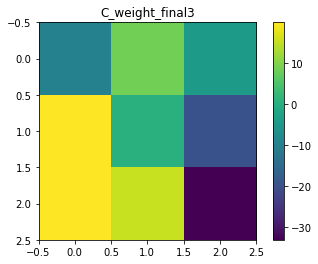

In [22]:
C_weight_final1 = save_C_weights[-1,:,:,:,0].reshape(3,3)
C_weight_final2 = save_C_weights[-1,:,:,:,1].reshape(3,3)
C_weight_final3 = save_C_weights[-1,:,:,:,2].reshape(3,3)
print (C_weight_final1)
plt.imshow(C_weight_final3)
plt.title('C_weight_final3')
plt.colorbar()

In [23]:
import numpy
numpy.savetxt("D:\Python\My_Python\deep-learning-cnn\cnn_with_device_fashionMnist_zhufangduo\\test_acc_log.txt", test_acc_log)
numpy.savetxt("D:\Python\My_Python\deep-learning-cnn\cnn_with_device_fashionMnist_zhufangduo\\C_weight_final1.txt",C_weight_final1)
numpy.savetxt("D:\Python\My_Python\deep-learning-cnn\cnn_with_device_fashionMnist_zhufangduo\\C_weight_final2.txt",C_weight_final2)
numpy.savetxt("D:\Python\My_Python\deep-learning-cnn\cnn_with_device_fashionMnist_zhufangduo\\C_weight_final3.txt",C_weight_final3)

In [24]:
print(model)

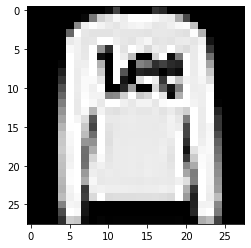

In [25]:
from keras.models import Model

sample = X_test[1,:,:,:].reshape(1,28,28,1)
conv2d_layer_model = Model(inputs=model.input, outputs=model.layers[0].output)
pooling_layer_model = Model(inputs=model.input, outputs=model.layers[1].output)

conv2d_feature=conv2d_layer_model.predict(sample)
pooling_feature = pooling_layer_model.predict(sample)
sample2 = X_test[1,:,:,:].reshape(28,28)
plt.imshow(sample2,cmap='gray')

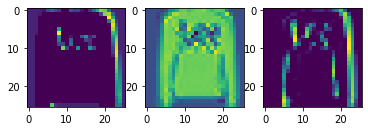

In [26]:
#conv2d layer output
for i in range(3):
    plt.subplot(1,3,i+1)
    figg = conv2d_feature[:,:,:,i].reshape(26,26)
    plt.imshow(figg, interpolation='none')
    

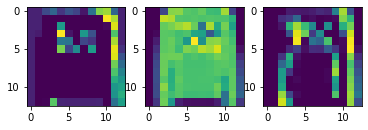

In [27]:
#pooling layer output
for i in range(3):
    plt.subplot(1,3,i+1)
    figg = pooling_feature[:,:,:,i].reshape(13,13)
    plt.imshow(figg, interpolation='none')